# Notebook traduit en français d'après celui du cours "Deep Learning" d'Alfredo Canziani de la New York University  : 
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/10-autoencoder.ipynb

In [1]:
# Importation de quelques libraires

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Convertir un vecteur en image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [3]:
# Afficher la routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
# Définir l'étape de chargement des données

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Définir l'architecture du modèle et la perte de reconstruction

# n = 28 x 28 = 784
d = 30 # pour l'auto-encodeur (couche cachée sous-complète)
# d = 500 # pour l'auto-encoder de débruitage (couche cachée sur-complète)


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [7]:
# Configurer l'optimiseur

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Commentez* ou *Décommenter* quelques lignes de code pour passer de *l'auto-encodeur standard* à celui de *débruitage*. 

N'oubliez pas de **(1)** modifier la taille de la couche cachée en conséquence, **(2)** re-générer le modèle, et **(3)** repasser les paramètres à l'optimiseur.

epoch [1/20], loss:1.1402
epoch [2/20], loss:1.0627
epoch [3/20], loss:1.0471
epoch [4/20], loss:1.0182
epoch [5/20], loss:1.0123
epoch [6/20], loss:1.0151
epoch [7/20], loss:0.9989
epoch [8/20], loss:1.0029
epoch [9/20], loss:0.9973
epoch [10/20], loss:0.9945
epoch [11/20], loss:0.9905


C:\Users\loick\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
C:\Users\loick\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


epoch [12/20], loss:0.9833
epoch [13/20], loss:0.9833
epoch [14/20], loss:0.9883
epoch [15/20], loss:0.9833
epoch [16/20], loss:0.9827
epoch [17/20], loss:0.9785
epoch [18/20], loss:0.9811
epoch [19/20], loss:0.9757
epoch [20/20], loss:0.9770


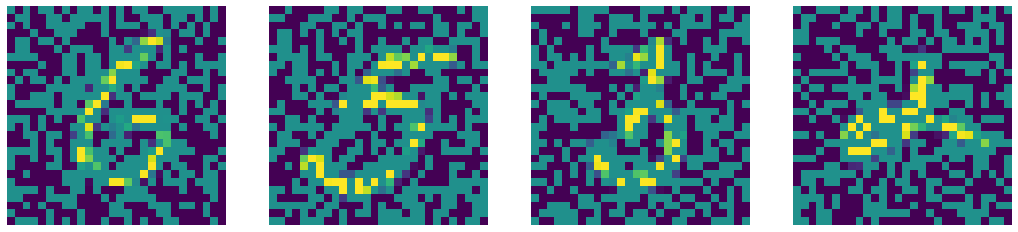

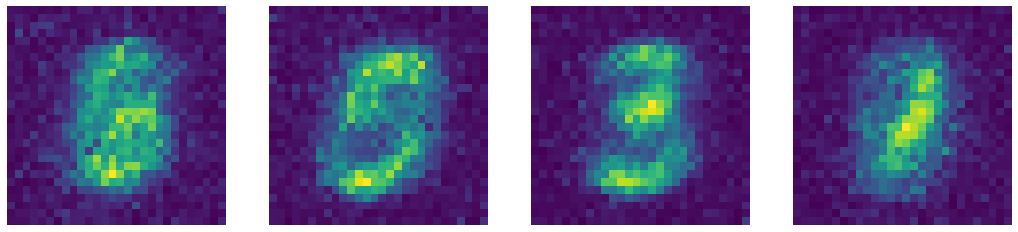

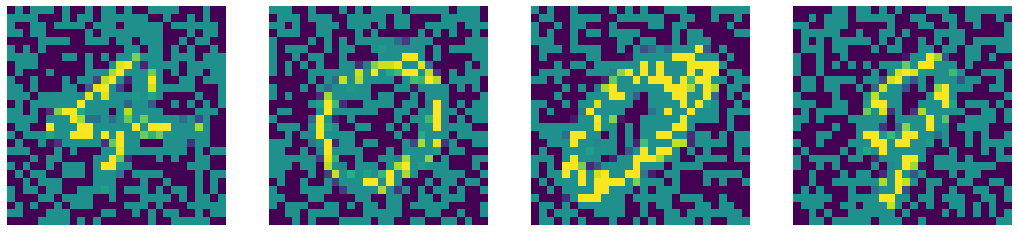

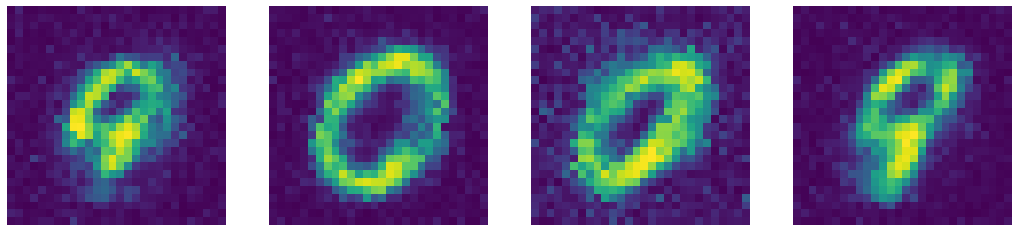

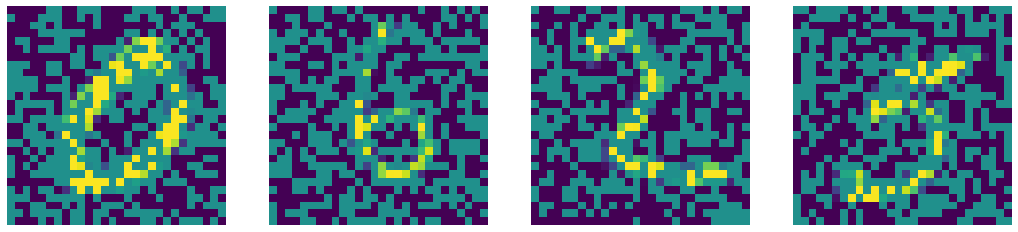

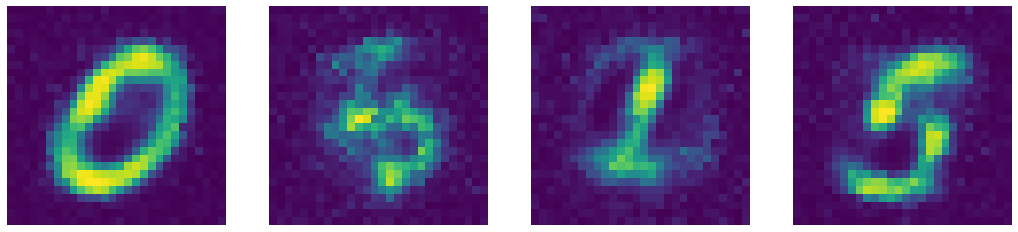

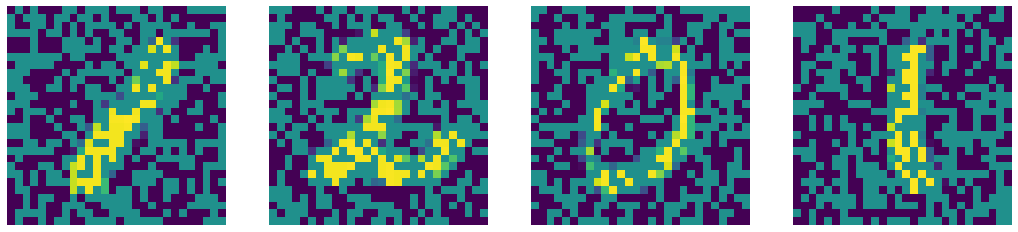

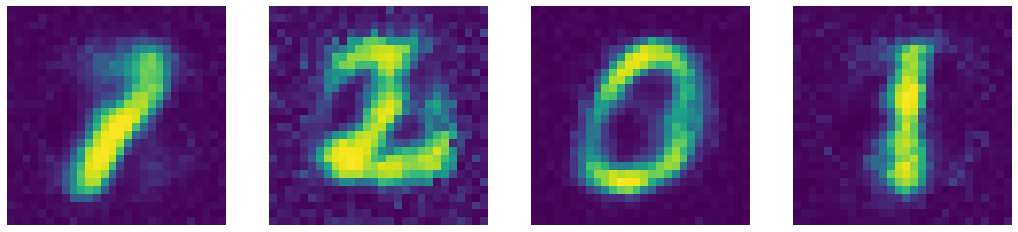

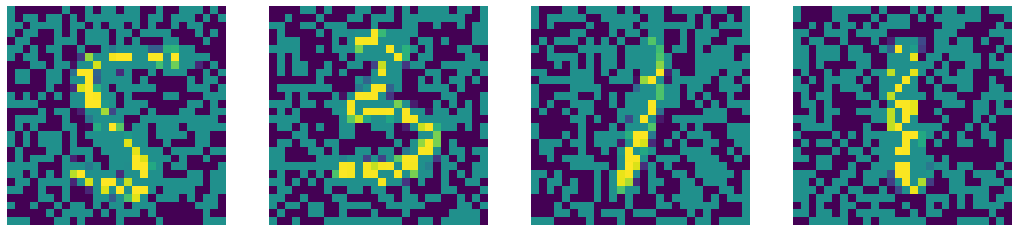

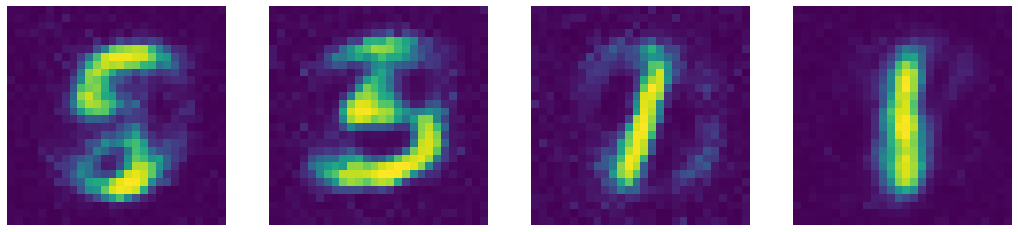

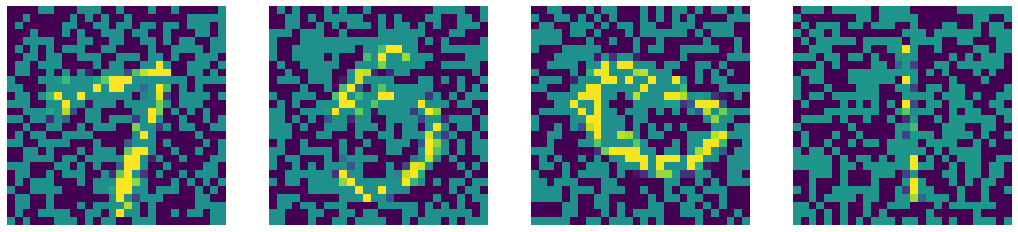

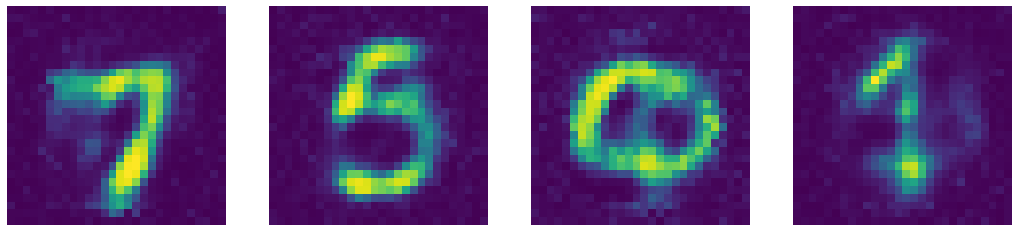

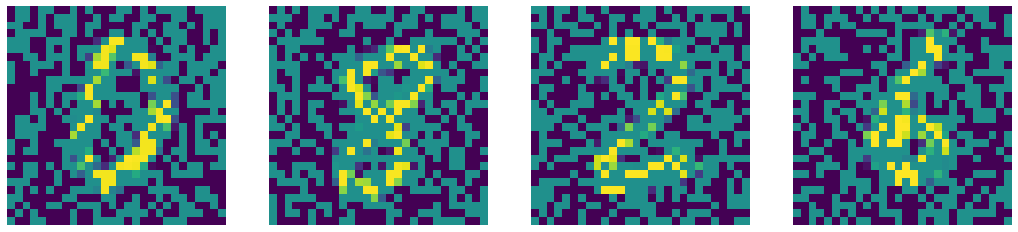

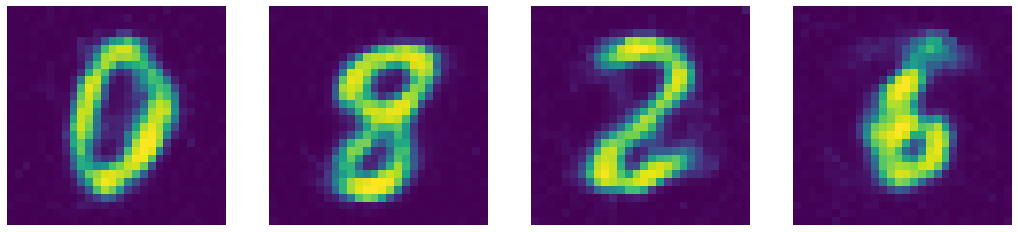

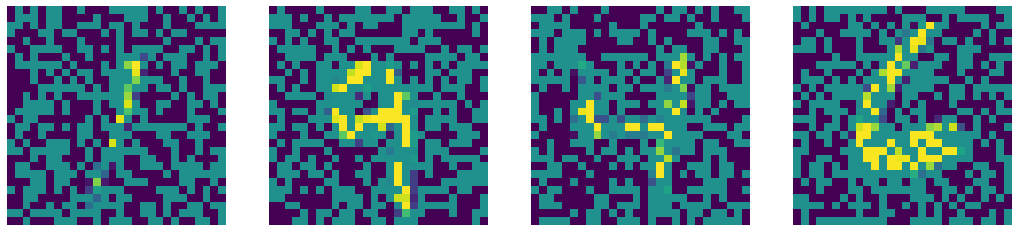

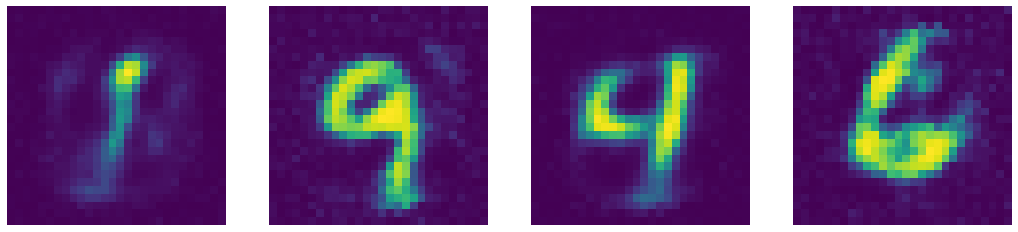

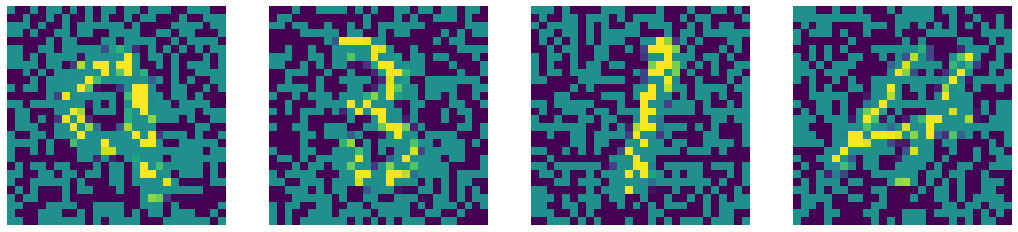

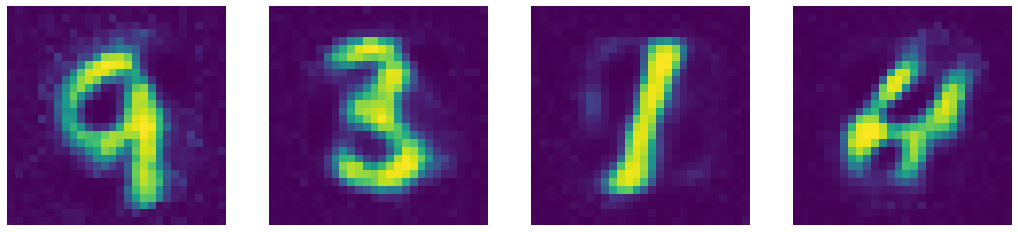

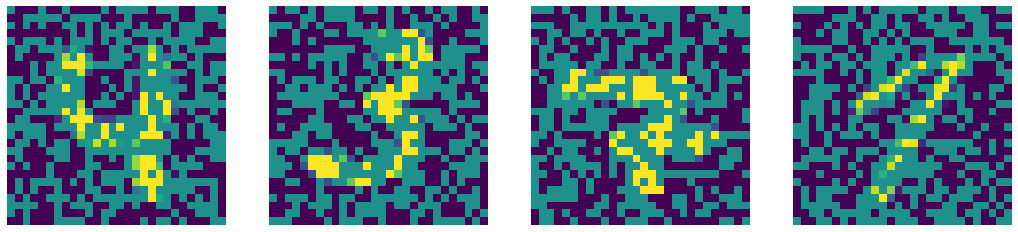

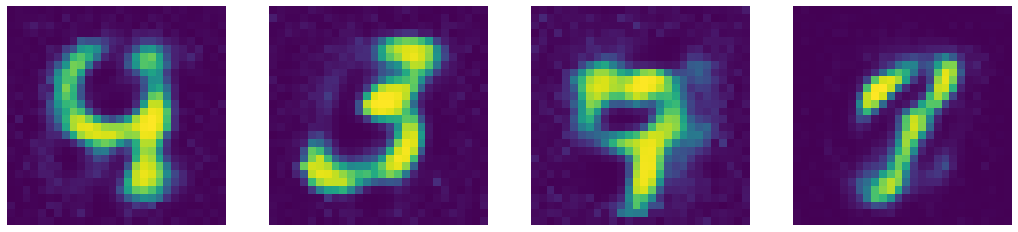

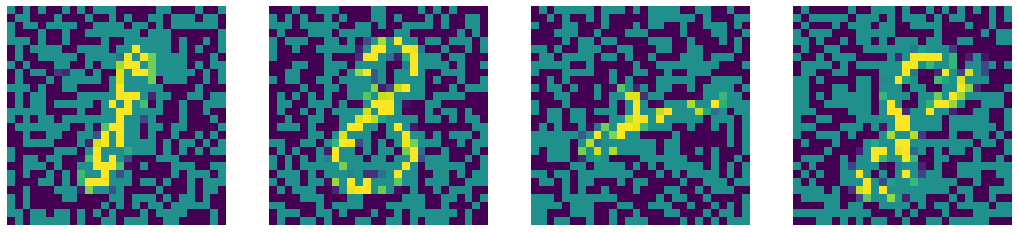

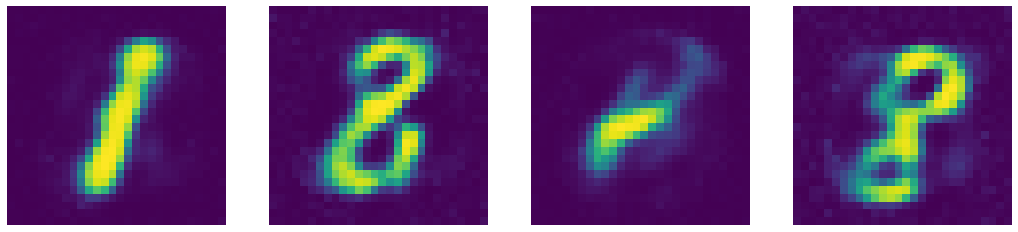

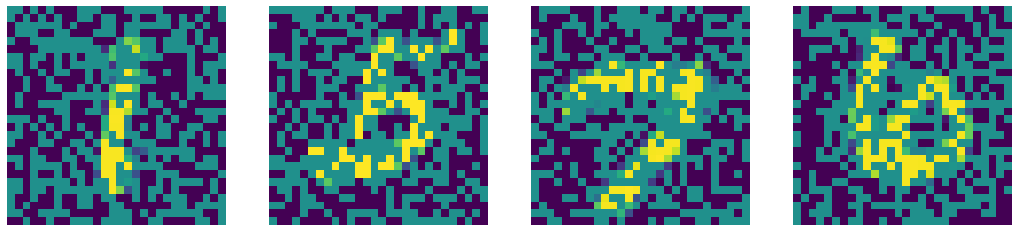

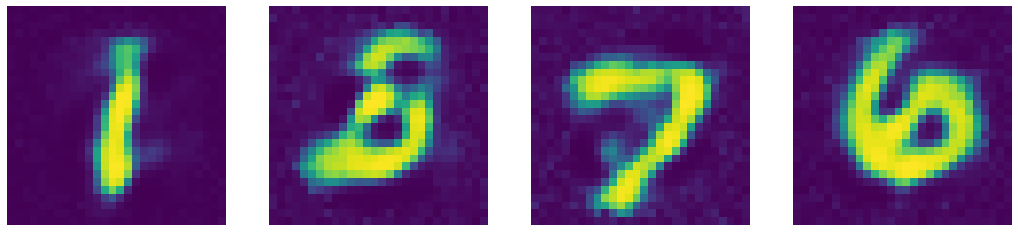

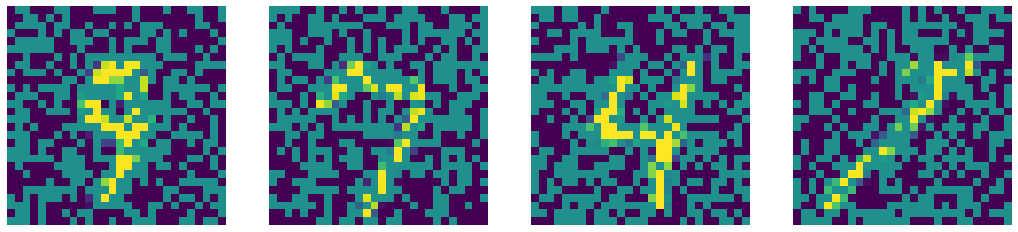

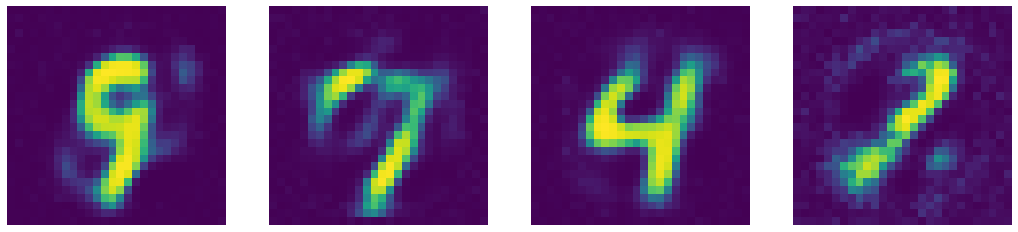

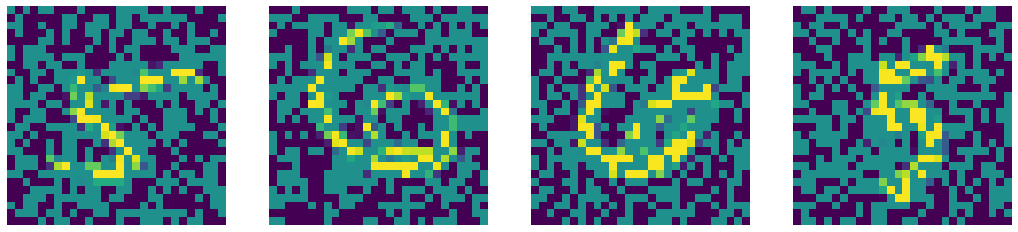

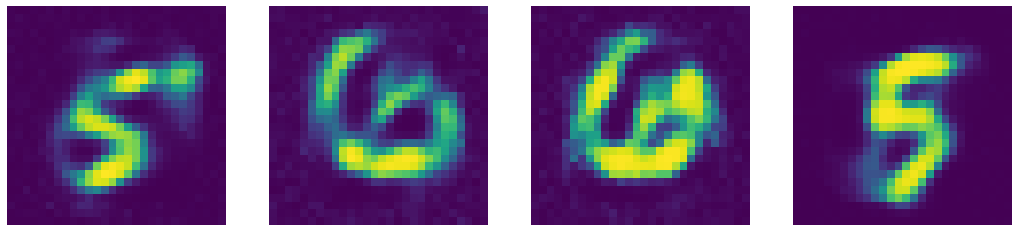

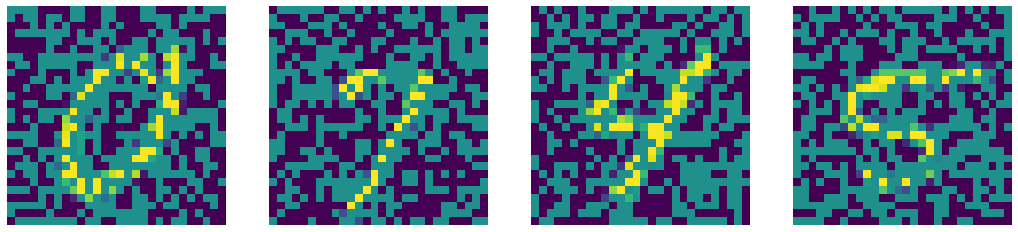

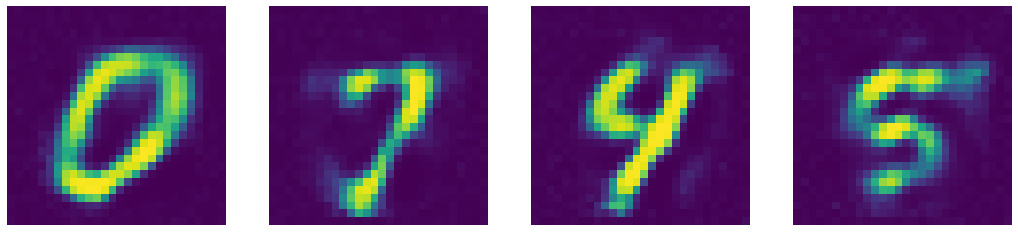

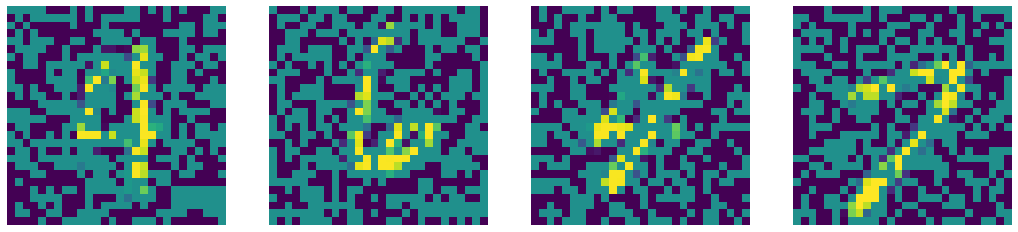

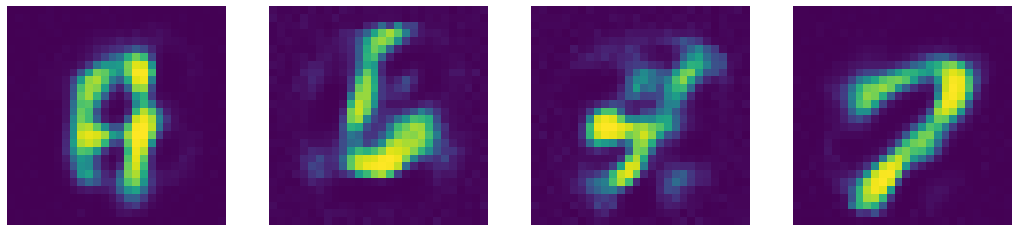

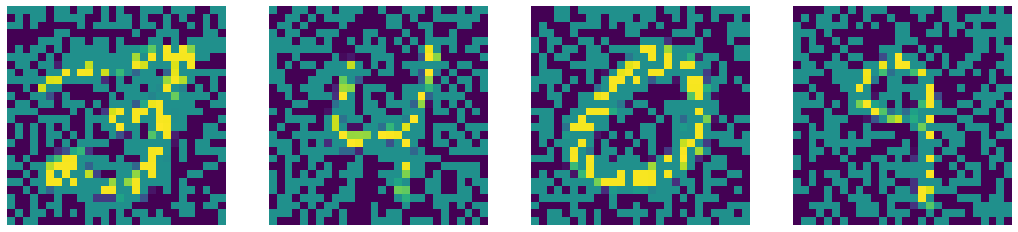

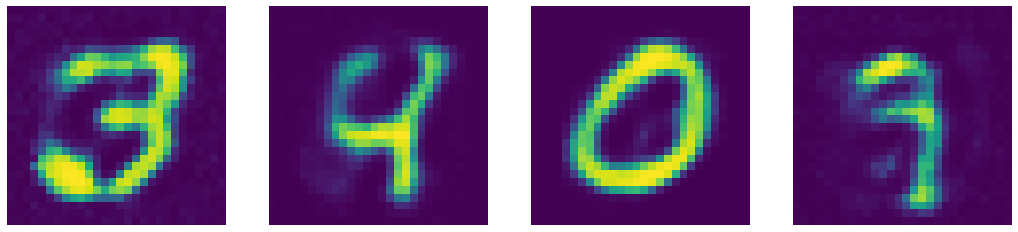

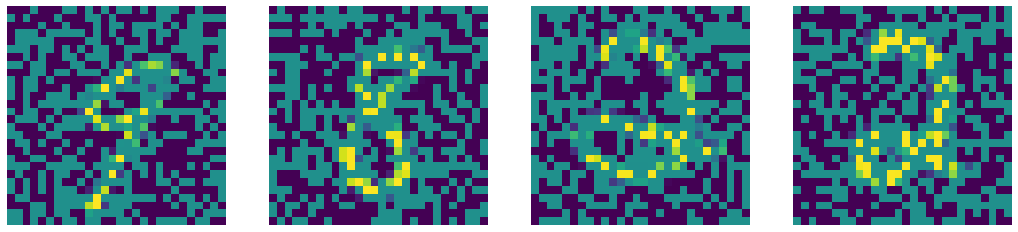

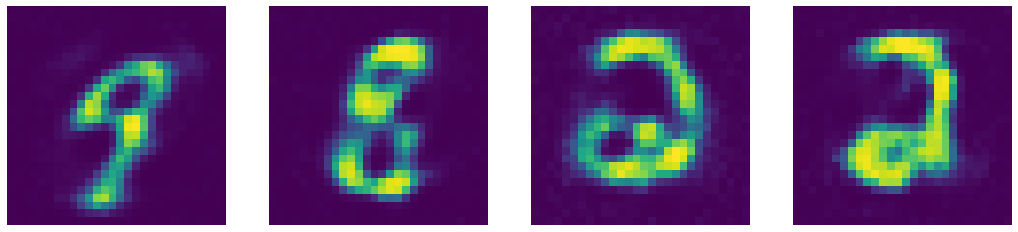

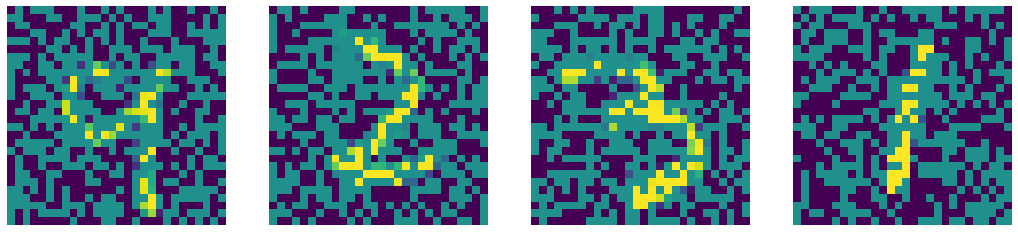

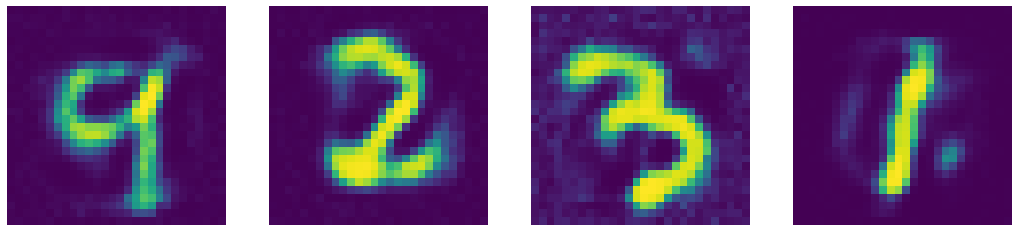

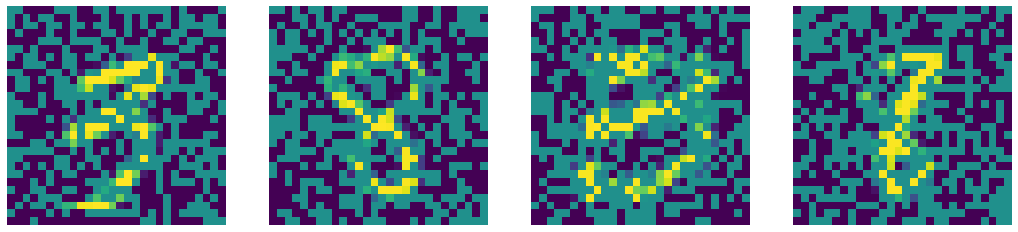

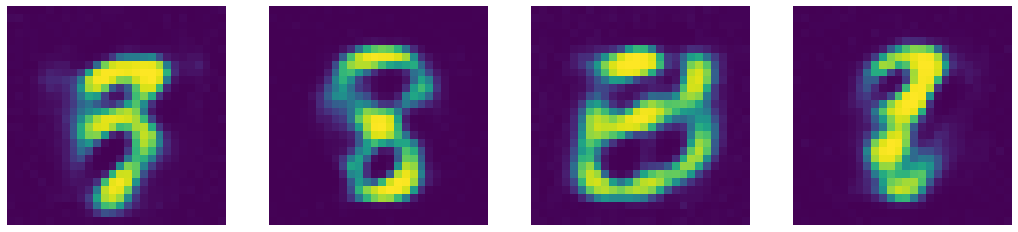

In [9]:
# Entrainer l'auto-encodeur standard ou de débruitage

num_epochs = 20
do = nn.Dropout()  # commenter pour l'AE standard
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)# commenter cette ligne et la suivante pour l'AE standard
        img_bad = (img * noise).to(device)  
        # ===================passe avant=====================
        output = model(img_bad)  #  <img> (pour l'AE std) , <img_bad> (pour l'AE de débruitage)
        loss = criterion(output, img_bad.data)
        # ===================passe arrière====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)  # indiquer (None, output) pour l'AE std, (img_bad, output) pour l'AE de débruitage

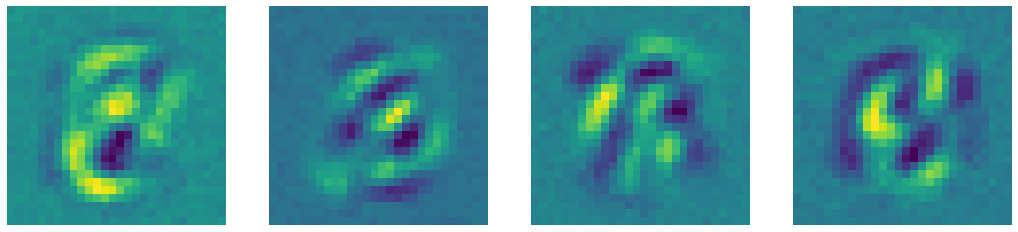

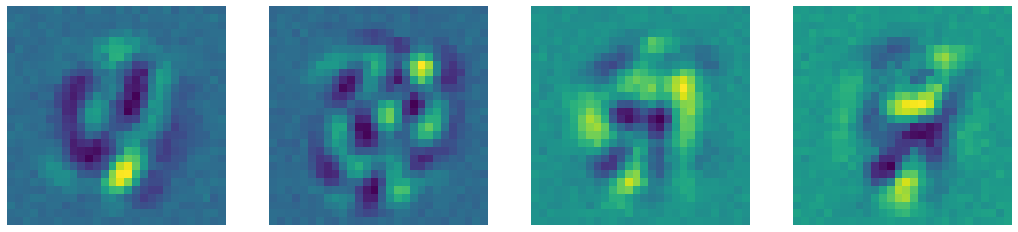

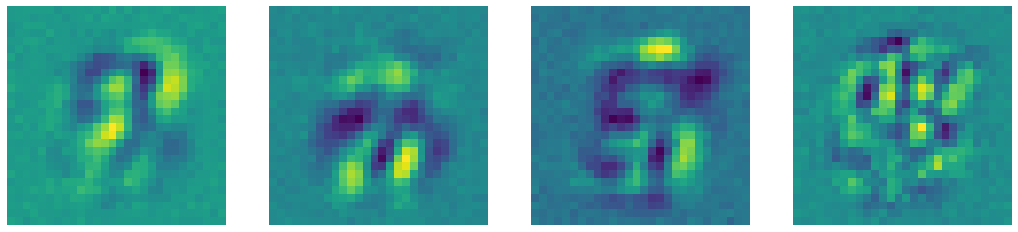

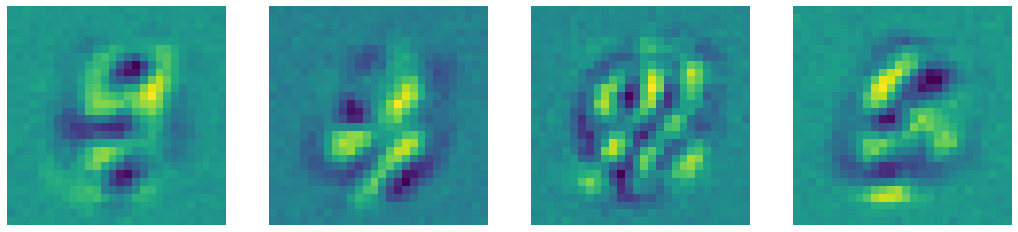

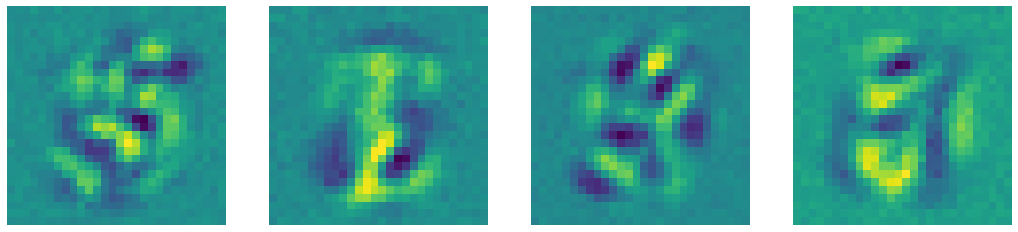

In [10]:
# Visualiser quelques noyaux de l'encodeur

display_images(None, model.encoder[0].weight, 5)

In [11]:
# Comparons les capacités de l'auto-codeur par rapport à OpenCV
# NE L'EXÉCUTER QU'APRÈS AVOIR ENTRAINÉ UN AE DE DÉBRUITAGE !!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [12]:
# Avec les méthodes Telea et Navier-Stokes

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

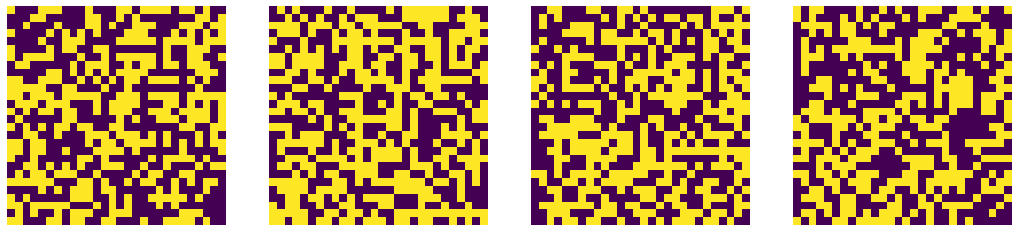

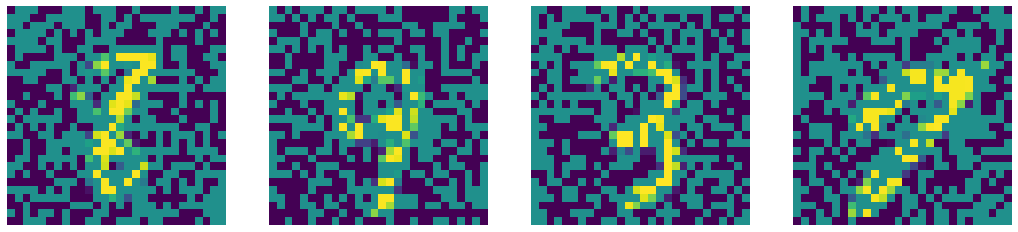

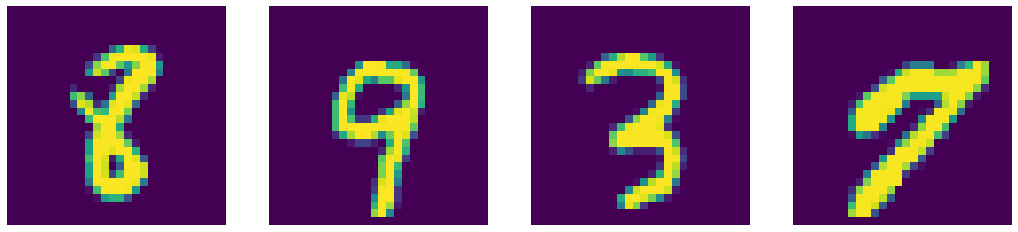

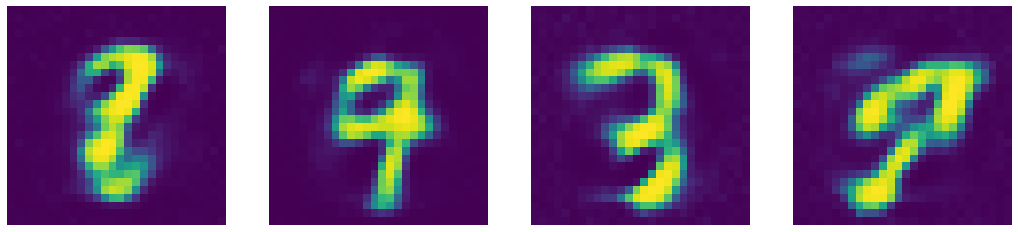

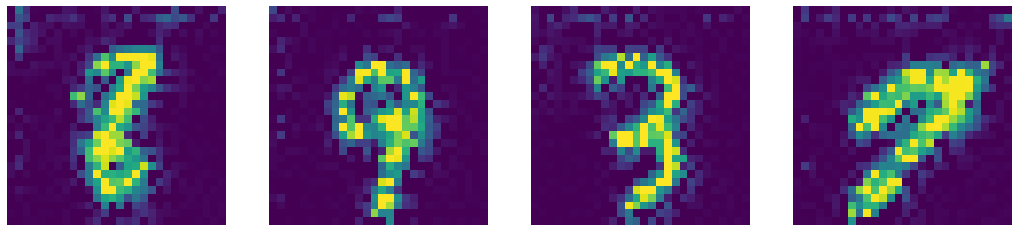

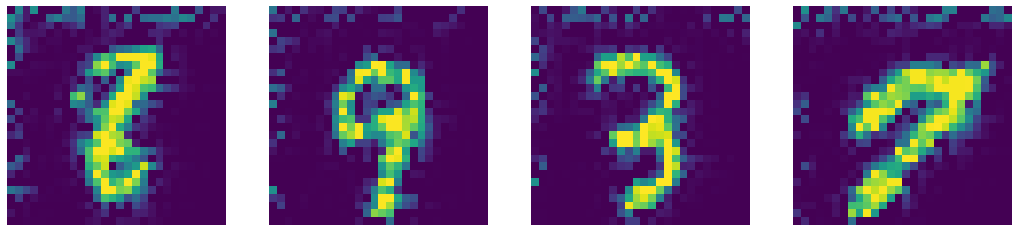

In [13]:
# Compare les resultas: [bruit], [img + bruit], [img], [AE, Telea, Navier-Stokes] 

with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)